# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import multinomial as mnom

In [4]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [5]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(20, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [9]:
X, y = read_dataset("spam")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [11]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    def fit(self, X, y):
        self.classes, counts = np.unique(y_train, return_counts=True)
        groupedByClassSum = X.groupby(y).sum()
        self.Pxy = (groupedByClassSum + self.alpha).divide(groupedByClassSum.sum(axis=1)+self.alpha*X.shape[1], axis=0)
        self.Py = counts/sum(counts)

    def predict(self, X):
        return self.log_proba(X).idxmax(axis=1)
    
    def log_proba(self, X):
        X_df = X.apply(lambda x: pandas.Series(mnom.logpmf(x.values, x.sum(axis=0), self.Pxy.values)), axis=1).fillna(0) + np.log(self.Py)
        X_df.columns = self.classes
        return X_df

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [12]:
class BoW:
    def __init__(self, X, voc_limit=1000, stemming=False):
        self.dict = {}
        self.stemming = stemming
        self.stemmer = SnowballStemmer("english")
        for x in X:
            for word in x.split(' '):
                prep_word = word.replace(',','').replace('.','').replace(' ','').replace(':','').lower()
                if(stemming):
                    prep_word = self.stemmer.stem(prep_word)
                if(len(prep_word)>1):
                    if prep_word in self.dict:
                        self.dict[prep_word]+=1
                    else:
                        self.dict[prep_word] = 1
        self.dict = sorted(self.dict.items(), key=lambda item: -item[1])[:voc_limit]
        self.dict = np.array([kv[0] for kv in self.dict])
        
    def _countOfWords(self, words):
        if(self.stemming):
            vfunc = np.vectorize(lambda word: words.count(self.stemmer.stem(word)))            
        else:
            vfunc = np.vectorize(lambda word: words.count(word))
        return vfunc(self.dict)
        
    def transform(self, X):
        res = []
        for x in X:
            res.append(self._countOfWords((x.lower().split(' '))))
        return pandas.DataFrame(res)

In [13]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [14]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9855371900826446, 'spam': 0.9459459459459459},
 {'ham': 0.9916839916839917, 'spam': 0.9090909090909091},
 0.9802867383512545)

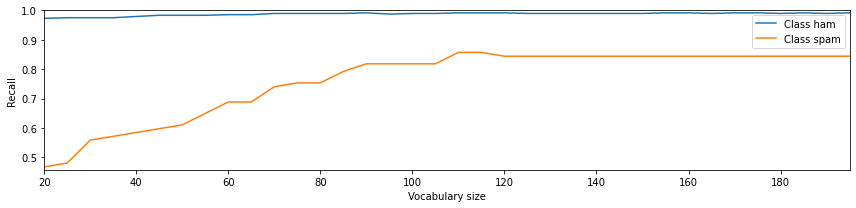

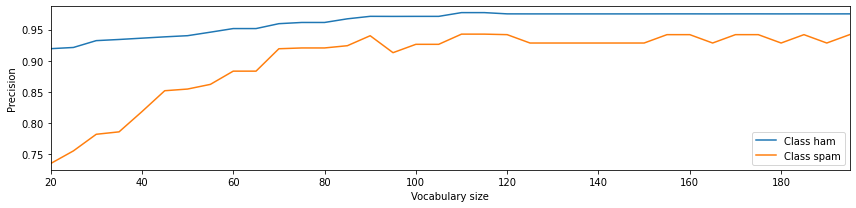

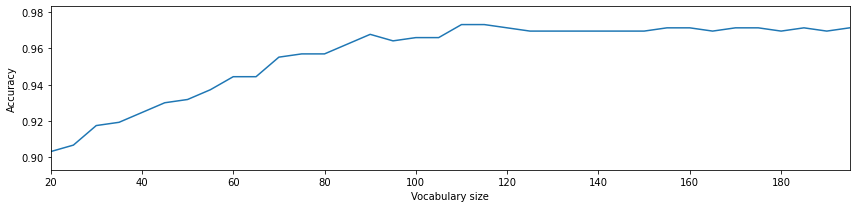

In [15]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [16]:
class BowStem (BoW):
    def __init__(self, X, voc_limit=1000):
        super(BowStem, self).__init__(X, voc_limit, stemming=True)

In [17]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [18]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9775967413441955, 'spam': 0.9850746268656716},
 {'ham': 0.997920997920998, 'spam': 0.8571428571428571},
 0.978494623655914)

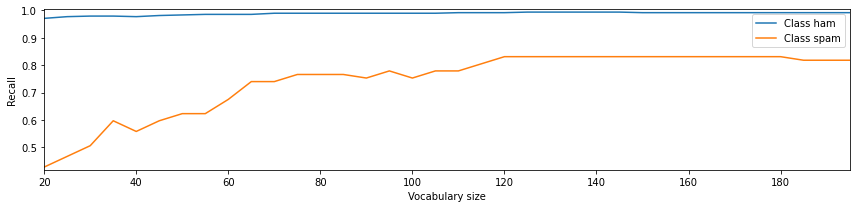

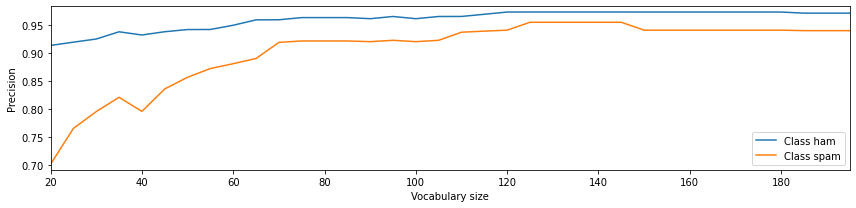

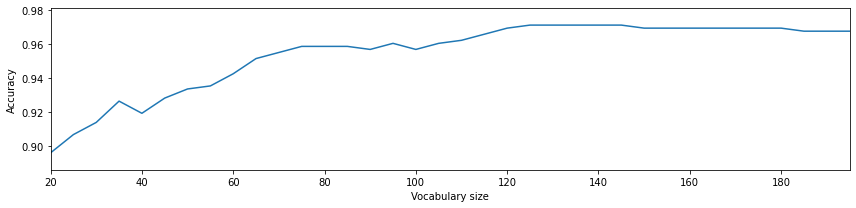

In [19]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)